In [11]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from brian2 import *
from scipy.sparse import lil_matrix

# the following dictionary defines style parameters to resemble the style of the figures in the paper, however, uncommenting these 2 lines will not affect the results
my_params = {'figure.dpi' : 300, 'figure.figsize' : [3,2],'font.size':8,'font.family':'Arial','axes.spines.top': False, 'axes.spines.right': False} #adjust some of the default style parameters
plt.rcParams.update(my_params) # update the default style parameters with the style parameters defined above
#To revert to the default style parameters, uncomment the following line
# plt.rcParams.update(matplotlib.rcParamsDefault)

In [17]:
#-------------------------------------------------------------------------
# Helper functions
#-------------------------------------------------------------------------

#Defines a number of helper functions that is used to build the network or to analyse the data

def shuffled_idx(N_pre,N_post, conn_prob):
    '''
    Generates an array of pre and post-synaptic indices to connect neurons in a homogenous way, meaning that each neuron has the same number of incoming and outgoing connections 
    :param N_pre: The number of presynaptic neurons
    :param N_post: The number of postsynaptic neurons
    :param conn_prob: The connection probability (between 0 and 1) between pre and post synaptic neurons
    :return: an array with indices for both the pre and post population
    '''
    indices_pre=[]
    indices_post=[]
    for i in range (int(N_post*conn_prob+0.5)):
        indices_pre.append(np.arange(N_pre))
    for j in range (int(N_pre*conn_prob+0.5)):
        indices_post.append(np.arange(N_post))
    indices_pre = np.concatenate(indices_pre)
    indices_post = np.concatenate(indices_post)
    np.random.shuffle(indices_pre)
    np.random.shuffle(indices_post)
    if len(indices_pre) != len(indices_post):
        return print('Pre and postsynaptic indices have different lengths')
    elif all(indices_pre==indices_post):
        return print('ATTENTION, pre and post indices are the same, use a different seed to shuffle the indices')
    else:
        return indices_pre, indices_post
    
def raster_interval_idx(start_time, stop_time, spike_times, select='idx'):
    '''function: Truncated spiketrains for defined intervals
    :param start_time: float for the start of the interval in seconds
    :param stop_time: float for the end of the interval in seconds
    :param spike_times: list with the unitless spiketimes in seconds
    :select: either 'spikes' or 'idx', when spikes then it gives the spiketrain and when idx then it gives the start_idx and stop_idx
    :return: truncated spiketrain when 'spikes' and start or stop idx when 'idx'
    '''
        
    if len(spike_times)==0 or start_time > spike_times[-1] or stop_time < spike_times[0]:
        start_id='no_spikes'
        stop_id = 'no_spikes'        
    else:
        start_id = next(x[0] for x in enumerate(spike_times) if x[1] >= start_time)
        if stop_time > spike_times[-1]:
            stop_id=len(spike_times)
        else:
            stop_id = next(x[0] for x in enumerate(spike_times) if x[1] >= stop_time)
        
    if select == 'spikes':
        if start_id=='no_spikes':
            return []
        else:
            return spike_times[start_id:stop_id]
    if select == 'idx':
        return start_id, stop_id
    
def spike_times_unitless(spike_times):
    '''function: Function that removes the unit of seconds from
    :param spike_times: dictionary returned by brian2 with spiketimes in seconds
    :return: Dictionary with spike times without units'''
    
    spike_times_unitless = {}
    for k, v in spike_times.items():  # items method returns a list of tuple pairs
        spike_times_unitless[k] = v / second  # The for loop removes the seconds from the spiketrains
    return spike_times_unitless
    
def pre_post_wo_autapses(N,conn_p):
    '''
    Function that generates an array of pre and post-synaptic indices to define recurrent connections between neurons from the same population but without autapses.
    Autapses (pre and post-synaptic neuron is the same) are problematic when changing inhibitory weights according to spike-time dependent plasticity rules
    :param: The number of neurons of the population
    :param conn_prob: The connection probability (between 0 and 1) between pre and post synaptic neurons
    :return: an array with indices to connect the neurons within the population recurrently
    '''
    indices = np.arange(N)
    nr_conn_per_neuron = int(N * conn_p + 0.5)
    post_idx = np.empty(nr_conn_per_neuron * N)
    pre_idx = np.copy(post_idx)
    j = 0
    for i in range (N):
        pre_i = np.delete(indices,i)
        np.random.shuffle(pre_i)
        pre_idx[j:j+nr_conn_per_neuron] = pre_i[0:nr_conn_per_neuron]
        post_idx[j:j+nr_conn_per_neuron] = np.ones(nr_conn_per_neuron)*i
        j += nr_conn_per_neuron
    return pre_idx.astype(int), post_idx.astype(int)

def spike_stats(spike_times, dend_burst_times):
    '''
    Function to compute the several of the neurometric parameters as defined in Naud et al. (2018). This includes the event times
    :param spike_times: spike times of the somatic compartment stored in a dictionary format
    :param dend_burst_times: burst times of the somatic compartment stored in a dictionary format
    :return: 
    '''
    
    def burst_detection(spike_times, dend_burst_times, burst_threshold=0.016):
        nr_bursts = len(dend_burst_times)
        nr_spikes = len(spike_times)
        burst_spikes = []
        burst_idx = []
        first_spike_of_burst = [] #--------------
        spikes_per_burst = []
        burst_times = np.empty(nr_bursts)
        events_idx = np.arange(nr_spikes)
        idx_last_spike = nr_spikes - 1
        burst = 0
        for time in dend_burst_times:
            spikes_in_burst = 0
            sp_in_local_burst = []
            sp_in_local_burst.append(time)
            idx_earlier_sp = np.where(time > spike_times)[0]
            if len(idx_earlier_sp) > 0:
                idx = int(idx_earlier_sp[-1])
                burst_spikes.append(spike_times[idx])
                burst_idx.append(idx)
                spikes_in_burst += 1
                while idx > 0 and spike_times[idx] - spike_times[idx - 1] < burst_threshold:
                    burst_spikes.append(spike_times[idx - 1])
                    burst_idx.append(idx - 1)
                    spikes_in_burst += 1
                    burst_times[burst] = spike_times[idx - 1]
                    sp_in_local_burst.append(spike_times[idx - 1])
                    idx = idx - 1
                burst += 1
            idx_later_sp = np.where(time > spike_times)[0]
            if len(idx_later_sp) > 0:
                idx = int(idx_later_sp[-1])
                while idx < idx_last_spike and spike_times[idx + 1] - spike_times[idx] < burst_threshold:
                    burst_spikes.append(spike_times[idx + 1])
                    burst_idx.append(idx + 1)
                    spikes_in_burst += 1
                    idx = idx + 1
                    # sp_in_local_burst.append(spike_times[idx + 1])
            spikes_per_burst.append(spikes_in_burst)
            first_spike_of_burst.append(np.sort(sp_in_local_burst)[0])
        burst_spikes = np.sort(burst_spikes)
        burst_idx = np.sort(burst_idx)
        event_idx = np.delete(events_idx, burst_idx)
        event_times = np.sort(np.concatenate((spike_times[event_idx], np.array(burst_times),np.array(first_spike_of_burst))))
        return burst_times, event_times, burst_spikes, spikes_per_burst, first_spike_of_burst

    nr_neurons = len(spike_times)

    burst_times = {}
    event_times = {}
    burst_spikes = {}
    spikes_per_burst = {}
    burst_times_first = {}

    for i in range(nr_neurons):
        burst_t, event_t, burst_sp, sp_per_burst,burst_t_first = burst_detection(spike_times[i], dend_burst_times[i])
        burst_spikes[i]=np.array(burst_sp)
        burst_times[i]=np.array(burst_t)
        event_times[i]=np.array(event_t)
        spikes_per_burst[i]=np.array(sp_per_burst)
        burst_times_first[i] = np.array(burst_t_first)
    return burst_times, event_times, burst_spikes, spikes_per_burst, burst_times_first

def cv(data):
    '''
    Function that computes the coefficient of variation of the data 
    :return: The coefficient of variation
    '''
    
    if len(data) >2: #If you only have 2 spikes then the difference is 1 number for which the CV will be zero
        cv = np.std(data) / np.mean(data)
    else:
        cv=NaN
    return cv

def bin_psth(variables, start_time, stop_time, bin_size, dt):
    '''
    Function that combines the value of the variable in bins by computing the mean of each bin. This reduces the temporal resolution of the data
    and smoothens the data. 
    :param variables: the variables of interest stored in a dictionary
    :param start_time: start time in seconds
    :param stop_time: stop time in seconds
    :param bin_size:  bin size in seconds
    :param dt: step_size of the simulation in seconds
    :return: the reduced time series of the data for each variable of the dictionary
    '''

    mean_variables = {}
    for key in variables.keys():
        if (len(variables[key])) == 0:
            print('No data for this variable')
        else:
            if len(variables[
                       key].shape) == 1:  # if one-dimensional array then shape will be 1, for 2d len of shape is 2
                nr_rows = 1
                variables[key] = variables[key].reshape(nr_rows, len(variables[key]))
            elif len(variables[key].shape) == 2:
                nr_rows = variables[key].shape[0]  # if 2D array then the first element of shape is nr_rows
            elif len(variables[key].shape) > 2:
                print('Input is not 1D or 2D array for {}'.format(key))
            if bin_size >= (stop_time - start_time):
                nr_columns = 1
            else:
                nr_bins = int((stop_time - start_time) / bin_size)
                nr_columns = np.copy(nr_bins)
                if np.allclose(nr_bins * bin_size,
                               stop_time - start_time) == False:  # if time to calculate averages over is not a multiple of the bins then allow to
                    nr_columns += 1  # store the average of the remaining time in another column

            array_mean = np.zeros((nr_rows, nr_columns), dtype = np.float32)
            for i in range(nr_rows):
                if bin_size >= (stop_time - start_time):
                    nr_bins = 1
                    array_mean = np.empty((nr_rows, nr_bins))
                    start_idx = int(start_time / dt + 0.5)
                    stop_idx = int(stop_time / dt + 0.5)
                    array_mean[i, 0] = np.mean(variables[key][i][start_idx:stop_idx])
                    array_times = np.array([(stop_time - start_time) / 2])
                else:
                    array_times = np.zeros((nr_columns), dtype = np.float32)
                    for j in range(nr_bins):
                        start_idx = int(((start_time + j * bin_size) / dt) + .5)
                        stop_idx = int(((start_time  + (j + 1) * bin_size) / dt) + .5)
                        array_mean[i, j] = np.mean(variables[key][i][start_idx:stop_idx])
                        array_times[j] = (start_time + j * bin_size + bin_size / 2)
                    if nr_columns > nr_bins:
                        array_mean[i, nr_columns - 1] = np.mean(variables[key][i][stop_idx:])
                        array_times[nr_columns - 1] = stop_time - (stop_time - (start_time + nr_bins * bin_size)) / 2
                mean_variables[key] = array_mean
            mean_variables['times'] = array_times.reshape(1, nr_columns)
    return mean_variables

def psth(spiketrains, dt, runtime):
    '''Function that returns the instantaneous rate of the whole population
    :param spiketrains: The spiketimes for all neurons saved in a dictionary
    :param dt = integration step size in seconds
    :param runtime = simulation time in seconds
    :return r: firing rate in Hz for each time bin
     '''

    N = len(spiketrains)
    steps = int(np.round(runtime / dt)) + 1
    # Initialise the sparse matrix
    pm = lil_matrix((N, steps), dtype='float32') #using a sparse matrix significantly reduces the size of the matrix

    for n in range(N):
        if len(spiketrains[n]) > 0:
            pi = ((spiketrains[n] / dt) + .5).astype('uint32')
            
            # fill the sparse matrix
            pm[n, pi] = True
    pm = pm.tocsr()
    r = np.squeeze(np.array(pm.mean(axis=0))) / dt  # take the column average over all cells and convert to Herz
    return r

In [18]:
#-------------------------------------------------------------------------
# Define the neuron models
#-------------------------------------------------------------------------

# Note that the neuron model for the PCs is different compared to Fig 1 and 2. Here we remove the spike-triggered somatic adaptation to allow for short interspike intervals. 
# None of the neuron populations receives background input so we removed the background input equation

def pyramidal_model(N):
    '''
    Define a two-compartmental neuron model of L5 PCs.
    The neurons are modeled in the Brian2 simulater using two separate compartments (soma and dend) with coupled variables.
    Implementing two separate compartments allows monitoring somatic and burst activity online and simultaneously.
    :param N: Number of neurons in the network
    :return: The somatic and dendritic compartment of L5 PCs
    '''
    
    #equations that define the dynamics in the somatic compartment
    soma_eqs = '''
    du_s/dt = - (u_s - EL)/tau_s + (g_s * m  + I_s) / C_s: volt (unless refractory) # Somatic voltage equation
    
    I_s = I_s_ext * pamp - g_gaba + g_ampa: amp # The total somatic input current
    
    dg_ampa/dt = -g_ampa/tau_ampa : amp # The excitatory synaptic current
    dg_gaba/dt = -g_gaba/tau_gaba : amp # The inhibitory synaptic current
    
    #variables defined in the dendritic compartment but also used in the dendritic compartment
    
    u_d : volt (linked)
    m: 1 (linked)
    '''

    #equations that define the dynamics of the dendritic compartment
    dend_eqs = '''
    du_d/dt = - (u_d - EL)/tau_d + (g_d * m + K + I_d + w_d) / C_d : volt
    dw_d/dt = (- w_d + a_w_d * (u_d - EL)) / tau_w_d : amp
    
    I_d = I_d_ext * pamp  - g_gaba + g_ampa : amp
    
    dg_ampa/dt = -g_ampa/tau_ampa : amp # The excitatory synaptic current
    dg_gaba/dt = -g_gaba/tau_gaba : amp # The inhibitory synaptic current
    
    m = 1/(1 + exp(-(u_d - Ed) / Dm)) : 1 #Sigmoidal function defining the non-linearity in the dendritic compartment
    Ca_spike = 1/(1 + exp(-(u_d - Ed2) / Dm2)) : 1 #filtered voltage of the dendritic voltage to isolate the calcium spikes
    
    lastspike_soma : second (linked)
    K = (((t-lastspike_soma) > K1) * ((t-lastspike_soma)< K2)) * c_d : amp
               '''

    # Parameters somatic compartment
    params_soma = {
        'tau_s': 16.0 * msecond,
        'C_s': 370.0 * pfarad,
        'g_s': 1300.0 * pamp,
        'tau_w_s': 100.0 * msecond,
        'EL': -0.07 * volt,

        'Ed': -0.038 * volt,
        'Dm': 0.006 * volt,
        'mu_s': 0 * pamp,
        'tau_ou_s': 2.0 * msecond,
        'tau_gaba': 10 * msecond,
        'tau_ampa': 5 * msecond,
                    }
    
    # Define the somatic compartment
    soma = NeuronGroup(N_PC, model=soma_eqs, threshold='u_s> -0.05 * volt',
                       reset='''
                             u_s = EL
                             ''',
                       refractory= 3 * msecond, namespace=params_soma, method='euler', dt = 0.1 * msecond)

    soma.u_s = 'EL + rand() * 0.01 * volt'     #initialise the somatic voltage around the resting potential

    # Parameters dendritic compartment
    params_dend = {
        'tau_d': 7.0 * msecond,
        'C_d': 170.0 * pfarad,
        'g_d': 1200.0 * pamp,
        'c_d': 2600.0 * pamp,
        'tau_w_d': 30.0 * msecond,
        'a_w_d': -28 * nsiemens, #Note that this value is different compared to Fig 1,2 and 4 (a_w_d = - 13 nS). 
        'EL': -0.07 * volt,
        'Ed': -0.038 * volt,
        'Dm': 0.006 * volt,
        'Ed2': -0.02 * volt,
        'Dm2': 0.00001 * volt,
        'K1': 0.499 * msecond,
        'K2': 2.501 * msecond,
        'tau_burst' : - 16 / np.log(0.1) * msecond,  #0.1 comes from the criterium under which burst_stop_trace has to fall

        'mu_d': 0 * pamp,
        'tau_ou_d': 2.0 * msecond,
        'tau_gaba': 10 * msecond,
        'tau_ampa': 5 * msecond,
                    }

    # Define the dendritic compartment
    dend = NeuronGroup(N, model=dend_eqs, threshold='u_d > -20 * mvolt',
                       refractory='u_d>-60 * mvolt', namespace=params_dend, method='euler',dt = 0.1 * msecond)
    
    # initialise dendritic voltage
    dend.u_d = 'EL + rand() * 0.01 * volt' #initialise the dendritic voltage around the resting potential
   
    #link dendritic and somatic variables
    soma.u_d = linked_var(dend.u_d)
    soma.m = linked_var(dend.m)
    dend.lastspike_soma = linked_var(soma.lastspike)

    return soma, dend


def SOM_interneurons(N):
    '''
    Neuron model of somatostatin positive interneurons (SOM) as defined in Naud et al. (2018).
    :param N: Number of SOM interneurons in the network
    :return: SOM interneuron population
    '''
    
    inh_eqs = '''
    du_i/dt = - (u_i - EL)/tau_SOM + (I_inh + w_i) / C_SOM: volt (unless refractory) # Voltage equation of SOMs
    dw_i/dt = - w_i / tau_w_SOM : amp # Adaptation variable of SOM interneurons

    I_inh = I_SOM_ext * pamp + g_ampa  - g_gaba : amp # The total input current to the SOMs
    
    dg_ampa/dt = -g_ampa/tau_ampa : amp # The excitatory synaptic current
    dg_gaba/dt = -g_gaba/tau_gaba : amp # The inhibitory synaptic current
    '''

    params_SOM = {
        'EL': -0.07 * volt,
        'tau_SOM': 20 * msecond,
        'C_SOM': 100.0 * pfarad,
        'b_w_SOM': -150.0 * pamp,
        'tau_w_SOM': 100 * msecond,

        'tau_gaba': 10 * msecond,
        'tau_ampa': 5 * msecond,
                    }

    # Define the inhibitory population
    inh = NeuronGroup(N, model=inh_eqs, threshold='u_i> -0.05 * volt',
                      reset='''
                            u_i = EL
                            w_i += b_w_SOM
                            ''',
                      refractory=3*msecond,
                      namespace=params_SOM, method='euler', dt = 0.1 * msecond)

    inh.u_i = 'EL + rand() * 0.01 * volt' #initialise the voltage around the resting potential

    return inh

def PV_interneurons(N):
    '''
    Neuron model of Parvalbumin positive interneurons (PV) as defined in Naud et al. (2018). 
    :param N: Number of PV interneurons in the network
    :return: PV interneuron population
    '''
    
    inh_eqs = '''
    du_i/dt = - (u_i - EL)/tau_PV + (I_inh) / C_PV: volt (unless refractory) # Voltage equation of PVs

    I_inh = I_PV_ext * pamp + g_ampa  - g_gaba : amp #The total input current to the PVs

    dg_ampa/dt = -g_ampa/tau_ampa : amp # The excitatory synaptic current
    dg_gaba/dt = -g_gaba/tau_gaba : amp # The inhibitory synaptic current
    '''

    params_PV = {
        'tau_PV': 10 * msecond,
        'C_PV': 100.0 * pfarad,
        'EL': -0.07 * volt,

        'tau_gaba': 10 * msecond,
        'tau_ampa': 5 * msecond,
    }

    # Define the inhibitory population
    inh = NeuronGroup(N, model=inh_eqs, threshold='u_i> -0.05 * volt',
                      reset='''
                            u_i = EL
                            ''',
                      refractory= 3 * msecond,
                      namespace=params_PV, method='euler', dt=0.1 * msecond)

    inh.u_i = 'EL + rand() * 0.01 * volt'  # initialise the voltage around the resting potential

    return inh

#-------------------------------------------------------------------------
# Define the synapse models
#-------------------------------------------------------------------------

def inh_plast_pre_post(pre, post, target, conn_p, weight, eta):
    '''
    Function implementing inhibitory plasticity rule where the plasticity is dependent on the pre and post-synaptic activity.
    :param pre: name of the presynaptic population
    :param post: name of the postsynaptic population
    :param target: target value to set the burst and/or burst rate
    :param conn_p: connection probability between pre and post populations
    :param weight: initial weights of the pre post conneccction
    :param eta: learning rate
    :return: synapse object
    '''

    params = {
            'max_weight': 1000,
            'eta': eta,
            'target':target
                       }

    pre_to_post = Synapses(pre, post,
                               '''
                               w : 1
                               dApre/dt = -Apre/tau_stdp : 1 (event-driven)
                               dApost/dt = -Apost/tau_stdp : 1 (event-driven)
                               ''',
                               on_pre='''
                                     Apre += 1.
                                     w = clip(w+eta*(Apost-target), 0, max_weight)
                                     g_gaba += w * pamp''',
                               on_post='''
                                     Apost += 1.
                                     w = clip(w+eta*Apre, 0, max_weight)
                                     ''', namespace=params, method='linear')

    pre_idx,post_idx = shuffled_idx(pre.N,post.N,conn_p) # Generates the indices of pre and post populations so that the connections are homogenous
    pre_to_post.connect(i=pre_idx, j=post_idx) #Connects the populations
    
    pre_to_post.w = weight # Initialisation of the connection weights

    return pre_to_post

def inh_plast_pre_post_ca(pre, post, target, conn_p, weight, eta):

    '''
    #Inhibitory plasticity model to control the burst rate using dendritic calcium spike (voltage rule) as signal for the post-synaptic activity
    :param pre: name of the presynaptic population
    :param post: name of the postsynaptic population
    :param  target: target in a.u.
    :param conn_p: connection probability between pre and post populations
    :param weight: initial weights of the pre post conneccction
    :return: synapse object
    '''

    params = {
            'target': target,
            'max_weight': 1000,
            'Ed2': -0.02 * volt,
            'Dm2': 0.00001 * volt,
            'eta': eta
                       }

    pre_to_post = Synapses(pre, post,
                               '''
                               w:1
                               dApre/dt=-Apre/tau_stdp : 1 (event-driven)
                               ''',
                               on_pre='''
                               Apre += 1.
                               w = clip(w+eta*(Ca_spike-target), 0, max_weight)
                               g_gaba += w * pamp''',
                               on_post = '''
                               w = clip(w+eta*Apre, 0, max_weight)
                               ''',
                               namespace=params, method='linear')

    pre_idx,post_idx = shuffled_idx(pre.N,post.N,conn_p)
    pre_to_post.connect(i=pre_idx, j=post_idx)

    pre_to_post.w = weight

    return pre_to_post

def exc_ampa(pre, post, conn_p, weight):
    '''
    Synapse model for excitatory synapses
    :param pre: name of the presynaptic population
    :param post: name of the postsynaptic population
    :param conn_p: connection probability between pre and post populations
    :param weight:  weights of the pre post connection
    :return: synapse object
    '''
        params = {
            'w': weight
                }

        pre_to_post = Synapses(pre, post,
                               on_pre='''
                               g_ampa += w * pamp
                               '''
                               ,namespace=params, method='linear')

        pre_idx,post_idx = shuffled_idx(pre.N,post.N,conn_p)
        pre_to_post.connect(i=pre_idx, j=post_idx)

        return pre_to_post

### In this section we simulate the entire microcircuit model of Fig 3 to plot the (burst) firing characteristics after learning the inhibitory weights.

Note that the simulation time takes a long time due to the higher number of neurons (compared to Fig 1 and 2) and the additional recurrent and excitatory connection. For this reason the simulation time is reduced to minimize the compute requirements for a laptop. This means that the firing rates of the PCs, SOMs and PVs did not converge to their respective target rates yet. However the simulation runs long enough to reach an doubly AI state.  For the final figures of the paper the firing rates did converge to target since the network was run on a compute cluster.

In [4]:
start_scope() #brian2 function, all objects created before this call will no longer be automatically included by the magic functions such as run()
simulation_time = 100 #Simulation time is reduced to be able to run the simulation on a lap top 
tau_stdp = 20 * msecond

#-------------------------------------------------------------------------
#Define the neuronal populations
#-------------------------------------------------------------------------

#Define the L5 Pyramidal neurons
N_PC = 8000 #Number of L5 PC cells
I_s_ext = 1500 #External somatic input current in pA 
I_d_ext = 500 #External dendritic input current in pA 
soma,dend= pyramidal_model(N_PC) #Function that defines the L5 pyramidal model 
dend_spikemonitor = SpikeMonitor(dend) # brian2 monitor recording spikes from the dendrites neuron group
soma_spikemonitor = SpikeMonitor(soma) # brian2 monitor recording spikes from the somatic neuron group
soma_rate = PopulationRateMonitor(soma) # brian2 monitor recording time-varying firing rate of the PCs
dend_rate = PopulationRateMonitor(dend) # brian2 monitor recording time-varying firing burstrate of the PCs
var_soma=StateMonitor(soma, ('g_gaba'),record=[0,1],dt=0.1*msecond) #Records the state variables of the somatic compartment
var_dend=StateMonitor(dend, ('g_gaba'),record=[0,1],dt=0.1*msecond) #Records the state variables of the dendritic compartment

#Define the SOM interneurons
N_SOM = 2000 # Number of SOM neurons
I_SOM_ext = 200 #External input current to the SOMs in pA 
SOM = SOM_interneurons(N_SOM) #Function that defines the SOM neuronal model
# SOM_spikemonitor = SpikeMonitor(SOM)
SOM_rate = PopulationRateMonitor(SOM) # brian2 monitor recording time-varying firing rate of the SOMs

#Define the PV interneurons
N_PV = 2000 # Number of PV neurons
I_PV_ext = 200 #External input current to the PVs in pA 
PV = PV_interneurons(N_PV) #Function that defines the PV neuronal model
PV_rate = PopulationRateMonitor(PV) # brian2 monitor recording time-varying firing rate of the PVs

#-------------------------------------------------------------------------
#Define plastic inhibitory connections between the different neuron populations
#-------------------------------------------------------------------------

#Connect SOM with dendrites
burst_target = 0.03 # burst rate in Hz
SOM_dend = inh_plast_pre_post_ca(SOM, dend, target  = burst_target ,  conn_p = 0.02, weight = 0.1, eta = 1) #original in paper is 0.1
var_SOM_dend=StateMonitor(SOM_dend, ('w'),record=np.arange(25),dt=100*msecond)  # brian2 monitor recording time-varying firing burstrate of the PCs

#Connect PV with somata
firing_target = 10 * Hz * 2 * tau_stdp # firing rate in Hz
PV_soma = inh_plast_pre_post(PV, soma, target = firing_target,conn_p = 0.02, weight = 0.1, eta = 0.1) #original in paper is 0.01
var_PV_soma=StateMonitor(PV_soma, ('w'),record=np.arange(25),dt=100*msecond) #Records the weigths of synaptic model

#Connect PV with PV
PV_target= 10 * Hz * 2 * tau_stdp
PV_PV = inh_plast_pre_post(PV, PV, target = PV_target,conn_p = 0.02, weight = 0.1, eta = 0.05) 
var_PV_PV=StateMonitor(PV_PV, ('w'),record=np.arange(25),dt=100*msecond) #Records the weights of of synaptic model

#-------------------------------------------------------------------------
#Define non-plastic excitatory connections between the different neuron populations
#-------------------------------------------------------------------------

#connect PC with PC
soma_soma = exc_ampa(soma, soma,conn_p = 0.02, weight = 25)

#connect PC with PV
soma_PV = exc_ampa(soma, PV, conn_p = 0.02, weight = 25)

#connect PC with SOM
soma_SOM = exc_ampa(soma, SOM, conn_p = 0.02, weight = 25)

#-------------------------------------------------------------------------
#Run the simulation
#-------------------------------------------------------------------------

run(simulation_time*second,report='stdout',profile=True)

Starting simulation at t=0. s for a duration of 100. s
0.3652 (0%) simulated in 10s, estimated 45m 28s remaining.
0.8335 (0%) simulated in 20s, estimated 39m 40s remaining.
1.4411 (1%) simulated in 30s, estimated 34m 12s remaining.
2.3322000000000003 (2%) simulated in 40s, estimated 27m 55s remaining.
3.2550000000000003 (3%) simulated in 50s, estimated 24m 46s remaining.
4.2551000000000005 (4%) simulated in 1m 0s, estimated 22m 31s remaining.
5.2186 (5%) simulated in 1m 10s, estimated 21m 12s remaining.
6.228800000000001 (6%) simulated in 1m 20s, estimated 20m 5s remaining.
7.2228 (7%) simulated in 1m 30s, estimated 19m 16s remaining.
8.257100000000001 (8%) simulated in 1m 40s, estimated 18m 31s remaining.
9.1112 (9%) simulated in 1m 50s, estimated 18m 18s remaining.
9.9826 (9%) simulated in 2m 0s, estimated 18m 2s remaining.
10.8451 (10%) simulated in 2m 10s, estimated 17m 49s remaining.
11.7379 (11%) simulated in 2m 20s, estimated 17m 33s remaining.
12.621199999999998 (12%) simulated

In [5]:
#-------------------------------------------------------------------------
#Store the data
#-------------------------------------------------------------------------

#It's recommended to store the data generated during the simulation to avoid having to rerun the long simulation in case the data 

data = {
'dend_sp' : dend_spikemonitor.spike_trains(),
'soma_sp' : soma_spikemonitor.spike_trains(),
'soma_r' : soma_rate.rate/hertz,
'dend_r' : dend_rate.rate/hertz,
'SOM_r' : SOM_rate.rate/hertz,
'PV_r' : PV_rate.rate/hertz,
       }

import pickle
a_file = open("data", "wb")
pickle.dump(data, a_file)
a_file.close()

mean CV 0.15816753628881336
mean CV 1.332042316422233
mean CV 0.7472415764240177


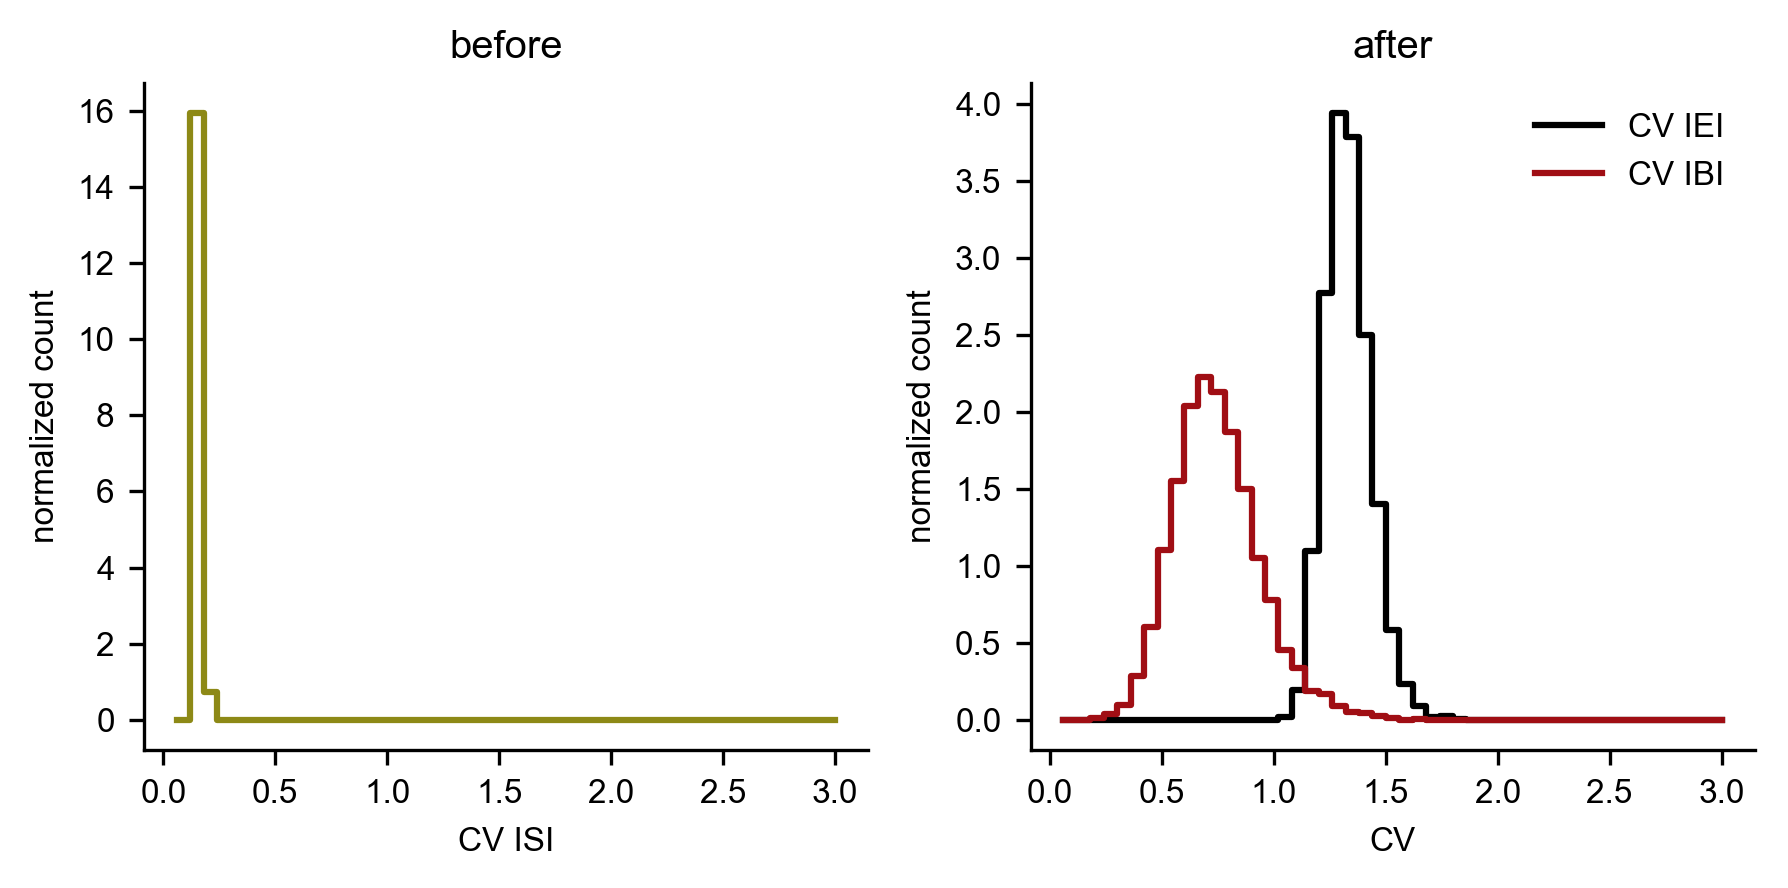

In [19]:
#-------------------------------------------------------------------------
# Plot the coefficient of variation before and after training
#-------------------------------------------------------------------------

#load the data

data_file = open("data", "rb")
data = pickle.load(data_file)

# In case you don't want to pickle the data you can also retrieve the burst and spike times directly from the spikemonitors
# spike_times_dend = spike_times_unitless(dend_spikemonitor.spike_trains())
# spike_times_soma = spike_times_unitless(soma_spikemonitor.spike_trains())

spike_times_dend = spike_times_unitless(data['dend_sp'])
spike_times_soma = spike_times_unitless(data['soma_sp'])

burst_times, spike_times_event, burst_spikes, spikes_per_burst, burst_times_first = spike_stats(spike_times_soma, spike_times_dend)

color_event  = 'k'
color_bursts = '#A00E14'
color_all_spikes = '#8D8916'

def histo_values(spike_times,start,stop):
    '''
    Function to compute the histogram of the coefficient of variation
    :param spike_times: spike times saved in dictionary format
    :param start: start time of the spike times
    :param stop: stop time of the spike times
    :return: values of the bins, boundaries of the bins
    '''
    CVs = []
    ISI = []
    for i in range(len(spike_times)):
        spike_times_slice = raster_interval_idx(start, stop, spike_times[i], 'spikes')
        ISI.append(np.diff(spike_times_slice))
        CVs.append(cv(ISI[i]))
    print('mean CV',np.nanmean(CVs))

    hist = np.histogram(CVs, bins = 50, range=(0, 3),density=True)
    count_values=hist[0]
    count_boundaries = hist[1][1:]
    return count_values, count_boundaries

plt.figure(figsize = (6,3))
plt.subplot(121)
plt.title('before')
start_before = 1
stop_before = 11
count_values, count_boundaries = histo_values(spike_times_soma,start_before,stop_before)
plt.step(count_boundaries, count_values, color= color_all_spikes)
plt.ylabel('normalized count')
plt.xlabel('CV ISI')

plt.subplot(122)
plt.title('after')
start_after = simulation_time -12
stop_after = simulation_time - 2
count_values, count_boundaries = histo_values(spike_times_event,start_after,stop_after)
plt.step(count_boundaries, count_values, label = 'CV IEI', color= color_event)
count_values, count_boundaries = histo_values(spike_times_dend,start_after,stop_after)
plt.step(count_boundaries, count_values, label = 'CV IBI',color= color_bursts)
plt.legend(loc = 'best',frameon=False)
plt.ylabel('normalized count')
plt.xlabel('CV')
plt.tight_layout()
plt.show()

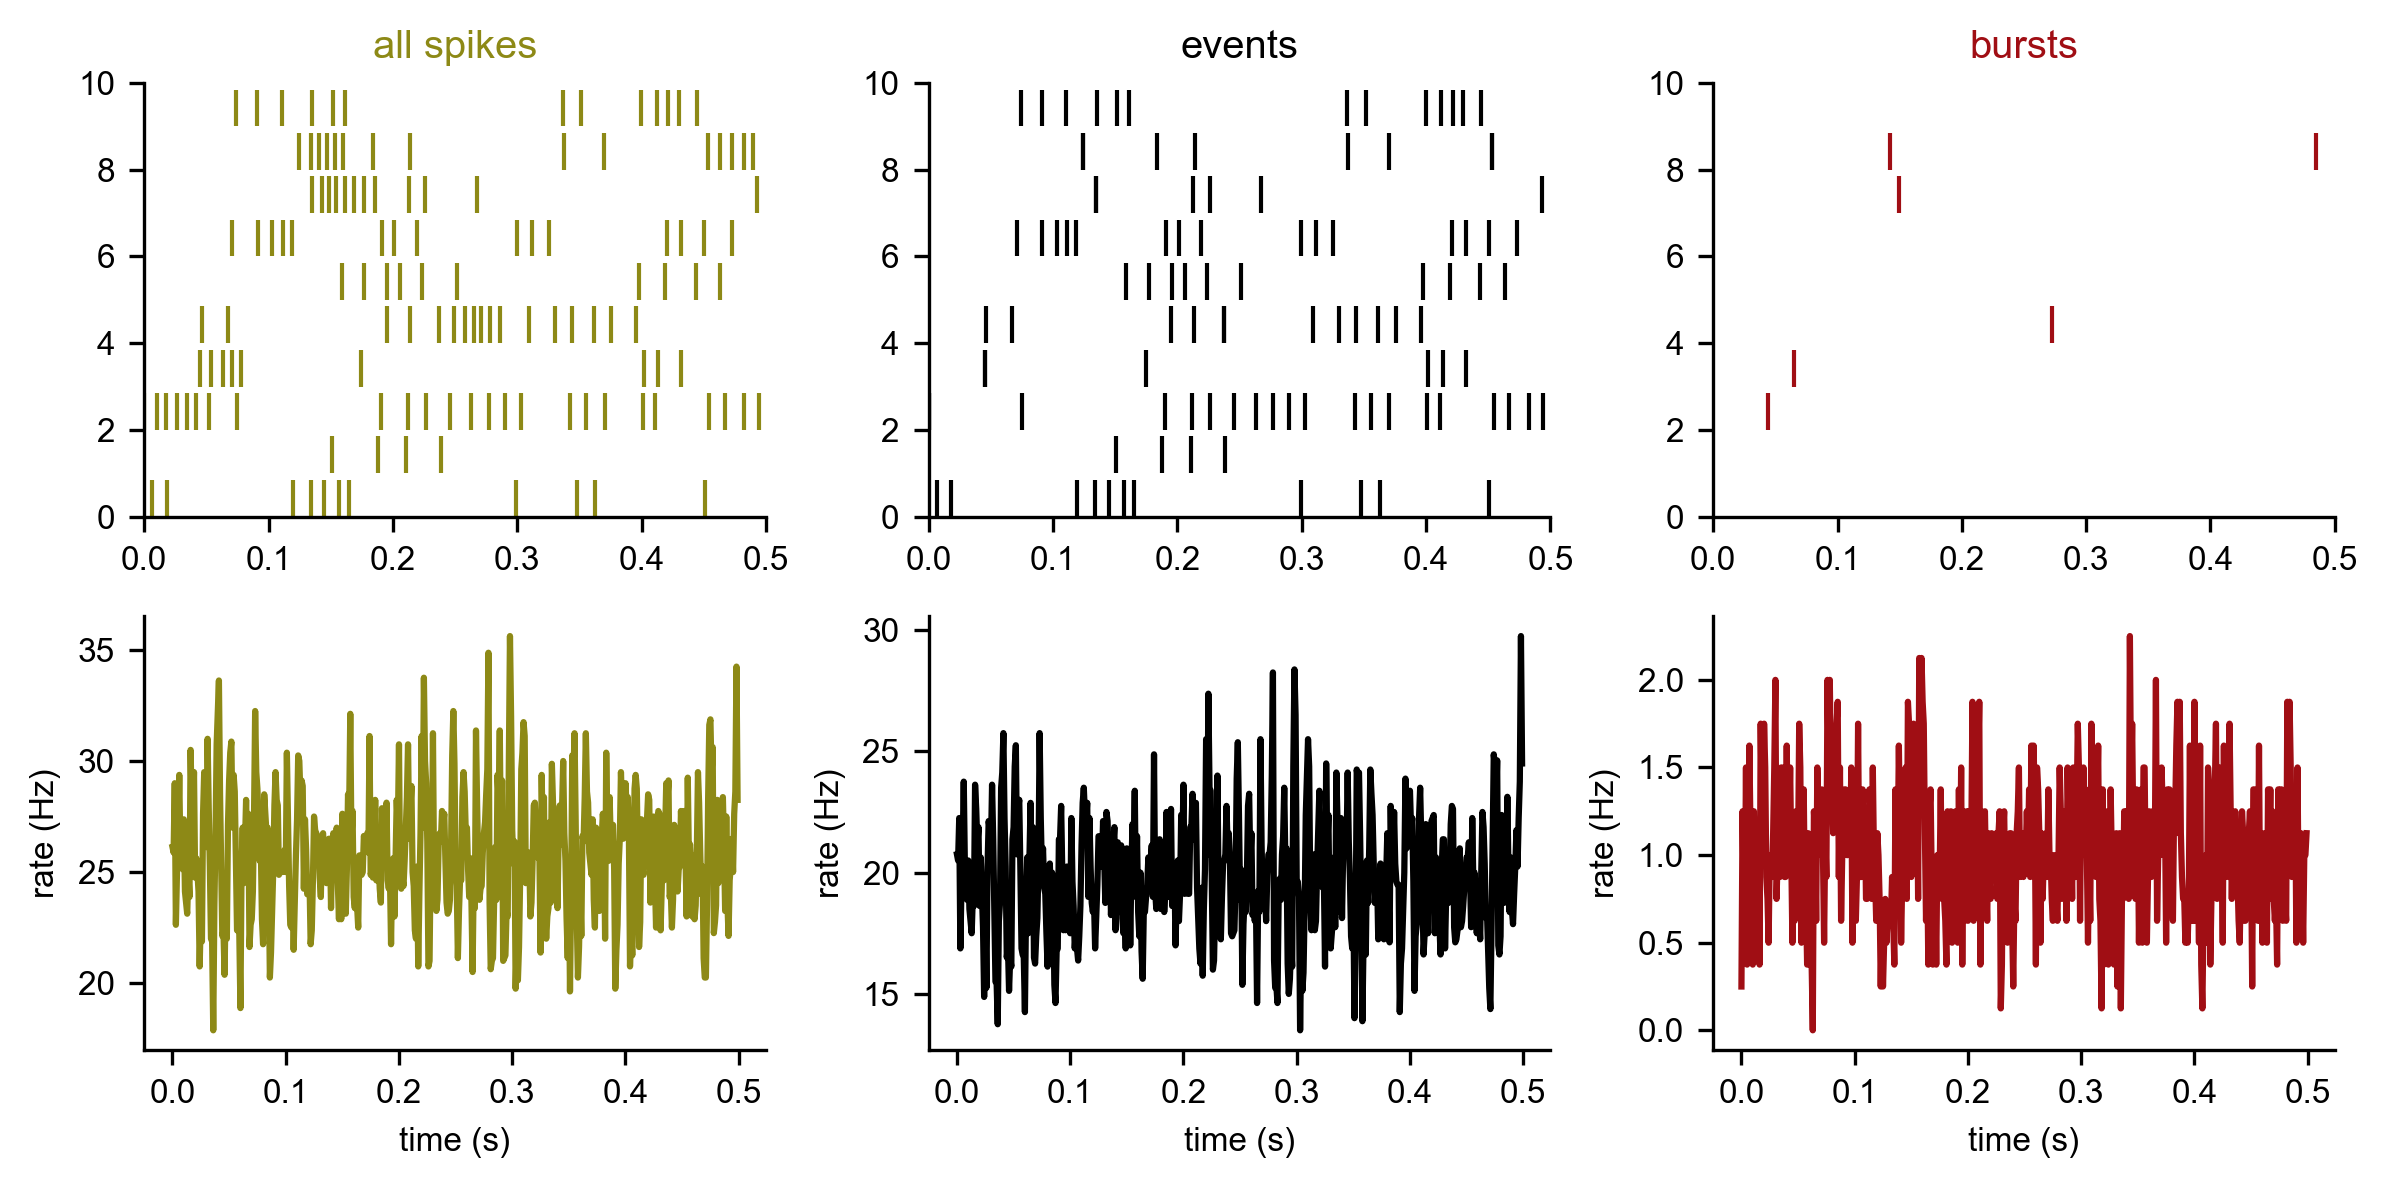

In [20]:
#-------------------------------------------------------------------------
# Plot the raster plots and firing rates for the different neurometric parameters
#-------------------------------------------------------------------------

start = simulation_time - 0.5 #last 500 mseconds of the simulation
stop = simulation_time

sp_times_soma = {}
sp_times_events = {}
sp_times_dend = {}
for i in range (len(spike_times_soma)):
    sp_times_soma[i] = np.array(raster_interval_idx(start, stop, spike_times_soma[i], 'spikes')) - start
    sp_times_events[i] = np.array(raster_interval_idx(start, stop, spike_times_event[i], 'spikes')) - start
    sp_times_dend[i] = np.array(raster_interval_idx(start, stop, spike_times_dend[i], 'spikes')) - start
    
psth_all_spikes = psth(sp_times_soma, dt = 0.0001, runtime = stop - start)
psth_events = psth(sp_times_events, dt = 0.0001, runtime = stop - start)
psth_bursts = psth(sp_times_dend, dt = 0.0001, runtime = stop - start)

dict_psth = {'p':psth_all_spikes,'e':psth_events,'b':psth_bursts }
psth_sampled = bin_psth(dict_psth, 0, stop - start, bin_size=0.001, dt=0.0001)

#Plot the data
color_soma  ='#8D8916'
color_dend = '#A00E14'
color_event = 'k'
nr_neurons = len(sp_times_soma)

time = np.arange(0,0.5,0.001)

plt.figure(figsize = (8,4))
plt.subplot(231)
plt.title('all spikes', color = color_soma)
y_pos = 0
for neuron in range(10):
    start_id, stop_id= raster_interval_idx(start, stop, spike_times_soma[neuron], 'idx')
    if start_id != 'no_spikes':
        plt.vlines(spike_times_soma[neuron][start_id:stop_id]  - start , y_pos, y_pos + 0.85,
                   color=color_soma, linewidth=1)
    y_pos += 1
plt.ylim(0,10)
plt.xlim(0,0.5)

plt.subplot(234)
plt.plot(time,psth_sampled['p'][0], color = color_soma)
plt.xlabel('time (s)')
plt.ylabel('rate (Hz)')

plt.subplot(232)
plt.title('events', color = color_event)
y_pos = 0
for neuron in range(10):
    start_id, stop_id= raster_interval_idx(start, stop, spike_times_event[neuron], 'idx')
    if start_id != 'no_spikes':
        plt.vlines(spike_times_event[neuron][start_id:stop_id]  - start , y_pos, y_pos + 0.85,
                   color=color_event, linewidth=1)
    y_pos += 1
plt.ylim(0,10)
plt.xlim(0,0.5)

plt.subplot(235)
plt.plot(time,psth_sampled['e'][0], color = color_event)
plt.xlabel('time (s)')
plt.ylabel('rate (Hz)')

plt.subplot(233)
plt.title('bursts', color = color_dend)
y_pos = 0
for neuron in range(10):
    start_id, stop_id= raster_interval_idx(start, stop, spike_times_dend[neuron], 'idx')
    if start_id != 'no_spikes':
        plt.vlines(spike_times_dend[neuron][start_id:stop_id]  - start , y_pos, y_pos + 0.85,
                   color=color_dend, linewidth=1)
    y_pos += 1
plt.ylim(0,10)
plt.xlim(0,0.5)

plt.subplot(236)
plt.plot(time,psth_sampled['b'][0], color = color_dend)
plt.xlabel('time (s)')
plt.ylabel('rate (Hz)')
plt.tight_layout()